In [1]:
import keras
import keras.backend as K
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, CuDNNLSTM, CuDNNGRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Conv2DTranspose, Embedding, Multiply, Activation

from functools import partial

from collections import defaultdict

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import isolearn.io as isoio
import isolearn.keras as isol

import matplotlib.pyplot as plt

import tensorflow as tf

from keras.backend.tensorflow_backend import set_session

import pandas as pd

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

class MySequence :
    def __init__(self) :
        self.dummy = 1

keras.utils.Sequence = MySequence

import isolearn.keras as iso

from sequence_logo_helper_protein import plot_protein_logo, letterAt_protein

class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            val : key for key, val in channel_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            if max_nt == 1 :
                seq += self.decode_map[argmax_nt]
            else :
                seq += "0"

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        encoding = np.array(encoding_mat[row_index, :].todense()).reshape(-1, 4)
        return self.decode(encoding)

class NopTransformer(iso.ValueTransformer) :
    
    def __init__(self, n_classes) :
        super(NopTransformer, self).__init__('nop', (n_classes, ))
        
        self.n_classes = n_classes
    
    def transform(self, values) :
        return values
    
    def transform_inplace(self, values, transform) :
        transform[:] = values
    
    def transform_inplace_sparse(self, values, transform_mat, row_index) :
        transform_mat[row_index, :] = np.ravel(values)


Using TensorFlow backend.


In [2]:
#Re-load cached dataframe (shuffled)

dataset_name = "coiled_coil_binders"

experiment = "baker_big_set_5x_negatives"

pair_df = pd.read_csv("pair_df_" + experiment + "_in_shuffled.csv", sep="\t")

print("len(pair_df) = " + str(len(pair_df)))

print(pair_df.head())

#Generate training and test set indexes
valid_set_size = 0.0005
test_set_size = 0.0995

data_index = np.arange(len(pair_df), dtype=np.int)

train_index = data_index[:-int(len(pair_df) * (valid_set_size + test_set_size))]
valid_index = data_index[train_index.shape[0]:-int(len(pair_df) * test_set_size)]
test_index = data_index[train_index.shape[0] + valid_index.shape[0]:]

print('Training set size = ' + str(train_index.shape[0]))
print('Validation set size = ' + str(valid_index.shape[0]))
print('Test set size = ' + str(test_index.shape[0]))


len(pair_df) = 890124
   Unnamed: 0                                       monomer_id_1  \
0           0  redesigned_closed_6_6_9_9middlesbobby_1_4_S_01...   
1           1  redesigned_closed_6_8_9_9middlesbobby_1_4_S_40...   
2           2  redesigned_closed_6_6_9_10middlesbobby_1_4_S_1...   
3           3  redesigned_closed_5_7_9_9middlesbobby_1_1_S_43...   
4           4  redesigned_closed_6_6_8_10middlesbobby_1_5_S_2...   

                                        monomer_id_2  \
0  redesigned_closed_6_6_8_10middlesbobby_1_5_S_2...   
1  redesigned_closed_5_7_8_10middlesbobby_1_2_S_0...   
2  redesigned_closed_6_6_9_9middlesbobby_1_4_S_07...   
3  redesigned_closed_5_6_9_9middlesbobby_1_1_S_25...   
4  redesigned_closed_6_6_8_9middlesbobby_1_5_S_16...   

                                         amino_seq_1  \
0  SEKDLLRLNREILEEIERIQKDLEELLERAERDAEGGLEELEKLVR...   
1  SEKEVMKEQIRLIRENIKAQEEILRLLKELERKGVDKEVEEVIKRI...   
2  DEEEILKILEENLRIQREIDRIHEEQVKALERITRRREDREEIEKL...   
3  STEDI

In [3]:
#Sub-select smaller dataset

n_train_pos = 20000
n_train_neg = 20000

n_test_pos = 2000
n_test_neg = 2000

orig_n_train = train_index.shape[0]
orig_n_valid = valid_index.shape[0]
orig_n_test = test_index.shape[0]

train_index_pos = np.nonzero((pair_df.iloc[train_index]['interacts'] == 1).values)[0][:n_train_pos]
train_index_neg = np.nonzero((pair_df.iloc[train_index]['interacts'] == 0).values)[0][:n_train_neg]

train_index = np.concatenate([train_index_pos, train_index_neg], axis=0)
np.random.shuffle(train_index)

test_index_pos = np.nonzero((pair_df.iloc[test_index]['interacts'] == 1).values)[0][:n_test_pos] + orig_n_train + orig_n_valid
test_index_neg = np.nonzero((pair_df.iloc[test_index]['interacts'] == 0).values)[0][:n_test_neg] + orig_n_train + orig_n_valid

test_index = np.concatenate([test_index_pos, test_index_neg], axis=0)
np.random.shuffle(test_index)

print('Training set size = ' + str(train_index.shape[0]))
print('Test set size = ' + str(test_index.shape[0]))


Training set size = 40000
Test set size = 4000


In [4]:
#Calculate sequence lengths

pair_df['amino_seq_1_len'] = pair_df['amino_seq_1'].str.len()
pair_df['amino_seq_2_len'] = pair_df['amino_seq_2'].str.len()


In [5]:
#Initialize sequence encoder

seq_length = 81

residue_map = {'D': 0, 'E': 1, 'V': 2, 'K': 3, 'R': 4, 'L': 5, 'S': 6, 'T': 7, 'N': 8, 'H': 9, 'A': 10, 'I': 11, 'G': 12, 'P': 13, 'Q': 14, 'Y': 15, 'W': 16, 'M': 17, 'F': 18, '#': 19}

encoder = IdentityEncoder(seq_length, residue_map)


In [6]:
#Construct data generators

class CategoricalRandomizer :
    
    def __init__(self, case_range, case_probs) :
        self.case_range = case_range
        self.case_probs = case_probs
        self.cases = 0
        
    def get_random_sample(self, index=None) :
        if index is None :
            return self.cases
        else :
            return self.cases[index]
    
    def generate_random_sample(self, batch_size=1, data_ids=None) :
        self.cases = np.random.choice(self.case_range, size=batch_size, replace=True, p=self.case_probs)

def get_amino_seq(row, index, flip_randomizer, homodimer_randomizer, max_seq_len=seq_length) :
    
    is_flip = True if flip_randomizer.get_random_sample(index=index) == 1 else False
    is_homodimer = True if homodimer_randomizer.get_random_sample(index=index) == 1 else False
    
    amino_seq_1, amino_seq_2 = row['amino_seq_1'], row['amino_seq_2']
    if is_flip :
        amino_seq_1, amino_seq_2 = row['amino_seq_2'], row['amino_seq_1']
    if is_homodimer and row['interacts'] < 0.5 :
        amino_seq_2 = amino_seq_1
    
    return amino_seq_1, amino_seq_2

flip_randomizer = CategoricalRandomizer(np.arange(2), np.array([0.5, 0.5]))
homodimer_randomizer = CategoricalRandomizer(np.arange(2), np.array([0.95, 0.05]))

batch_size = 32

data_gens = {
    gen_id : iso.DataGenerator(
        idx,
        { 'df' : pair_df },
        batch_size=(idx.shape[0] // batch_size) * batch_size,
        inputs = [
            {
                'id' : 'amino_seq_1',
                'source_type' : 'dataframe',
                'source' : 'df',
                #'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: (get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[0] + "#" * seq_length)[:seq_length],
                'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[0],
                'encoder' : IdentityEncoder(seq_length, residue_map),
                'dim' : (1, seq_length, len(residue_map)),
                'sparsify' : False
            },
            {
                'id' : 'amino_seq_2',
                'source_type' : 'dataframe',
                'source' : 'df',
                #'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: (get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[1] + "#" * seq_length)[:seq_length],
                'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[1],
                'encoder' : IdentityEncoder(seq_length, residue_map),
                'dim' : (1, seq_length, len(residue_map)),
                'sparsify' : False
            },
            {
                'id' : 'amino_seq_1_len',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: len(get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[0]),
                'encoder' : lambda t: t,
                'dim' : (1,),
                'sparsify' : False
            },
            {
                'id' : 'amino_seq_2_len',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: len(get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[1]),
                'encoder' : lambda t: t,
                'dim' : (1,),
                'sparsify' : False
            }
        ],
        outputs = [
            {
                'id' : 'interacts',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index: row['interacts'],
                'transformer' : NopTransformer(1),
                'dim' : (1,),
                'sparsify' : False
            }
        ],
        randomizers = [flip_randomizer, homodimer_randomizer],
        shuffle = True
    ) for gen_id, idx in [('train', train_index), ('valid', valid_index), ('test', test_index)]
}


In [7]:
#Load data matrices

[x_1_train, x_2_train, l_1_train, l_2_train], [y_train] = data_gens['train'][0]
[x_1_test, x_2_test, l_1_test, l_2_test], [y_test] = data_gens['test'][0]

print("x_1_train.shape = " + str(x_1_train.shape))
print("x_2_train.shape = " + str(x_2_train.shape))
print("x_1_test.shape = " + str(x_1_test.shape))
print("x_2_test.shape = " + str(x_2_test.shape))

print("l_1_train.shape = " + str(l_1_train.shape))
print("l2_train.shape = " + str(l_2_train.shape))
print("l_1_test.shape = " + str(l_1_test.shape))
print("l2_test.shape = " + str(l_2_test.shape))

print("y_train.shape = " + str(y_train.shape))
print("y_test.shape = " + str(y_test.shape))


x_1_train.shape = (40000, 1, 81, 20)
x_2_train.shape = (40000, 1, 81, 20)
x_1_test.shape = (4000, 1, 81, 20)
x_2_test.shape = (4000, 1, 81, 20)
l_1_train.shape = (40000, 1)
l2_train.shape = (40000, 1)
l_1_test.shape = (4000, 1)
l2_test.shape = (4000, 1)
y_train.shape = (40000, 1)
y_test.shape = (4000, 1)


In [8]:
#Define sequence templates

sequence_templates = [
    '$' * i + '@' * (seq_length - i)
    for i in range(seq_length+1)
]

sequence_masks = [
    np.array([1 if sequence_templates[i][j] == '$' else 0 for j in range(len(sequence_templates[i]))])
    for i in range(seq_length+1)
]


In [9]:
#Load cached dataframe (shuffled)

dataset_name = "coiled_coil_binders"

experiment = "coiled_coil_binders_alyssa"

data_df = pd.read_csv(experiment + ".csv", sep="\t")

print("len(data_df) = " + str(len(data_df)))

test_df = data_df.copy().reset_index(drop=True)

batch_size = 32
test_df = test_df.iloc[:(len(test_df) // batch_size) * batch_size].copy().reset_index(drop=True)

print("len(test_df) = " + str(len(test_df)))

print(test_df.head())


len(data_df) = 481
len(test_df) = 480
                                        monomer_id_1  \
0  redesigned_closed_5_7_9_9middlesbobby_1_1_S_39...   
1  redesigned_closed_6_6_9_9middlesbobby_1_4_S_07...   
2  redesigned_closed_6_6_9_9middlesbobby_1_4_S_08...   
3  redesigned_closed_5_6_9_10middlesscott_1_1_S_3...   
4  redesigned_closed_6_6_9_10middlesbobby_1_4_S_1...   

                                        monomer_id_2  \
0  redesigned_closed_5_7_9_9middlesbobby_1_1_S_39...   
1  redesigned_closed_6_6_9_9middlesbobby_1_4_S_07...   
2  redesigned_closed_6_6_9_9middlesbobby_1_4_S_08...   
3  redesigned_closed_5_6_9_10middlesscott_1_1_S_3...   
4  redesigned_closed_6_6_9_10middlesbobby_1_4_S_1...   

                                         amino_seq_1  \
0  DEEELLKLIEDLLKSNKELLDLSKKNLRLLRELVRERNMDDTALRK...   
1  SEKELLELLRELIEDLDRDVKLLRRNVDLHRRVAREGMREELIKKS...   
2  SEEERITEIVKRVEELLRRYEELVKEYKRVLEELRRELREEEQKEL...   
3  SDEEELDEIIKRSEEVMREVEEIDKRVEDIVRKAAKEGASELVKRS...   
4  TVKEL

In [10]:
#Construct test data

batch_size = 32

test_gen = iso.DataGenerator(
    np.arange(len(test_df), dtype=np.int),
    { 'df' : test_df },
    batch_size=(len(test_df) // batch_size) * batch_size,
    inputs = [
        {
            'id' : 'amino_seq_1',
            'source_type' : 'dataframe',
            'source' : 'df',
            #'extractor' : lambda row, index: (row['amino_seq_1'] + "#" * seq_length)[:seq_length],
            'extractor' : lambda row, index: row['amino_seq_1'],
            'encoder' : IdentityEncoder(seq_length, residue_map),
            'dim' : (1, seq_length, len(residue_map)),
            'sparsify' : False
        },
        {
            'id' : 'amino_seq_2',
            'source_type' : 'dataframe',
            'source' : 'df',
            #'extractor' : lambda row, index: row['amino_seq_2'] + "#" * seq_length)[:seq_length],
            'extractor' : lambda row, index: row['amino_seq_2'],
            'encoder' : IdentityEncoder(seq_length, residue_map),
            'dim' : (1, seq_length, len(residue_map)),
            'sparsify' : False
        },
        {
            'id' : 'amino_seq_1_len',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : lambda row, index: len(row['amino_seq_1']),
            'encoder' : lambda t: t,
            'dim' : (1,),
            'sparsify' : False
        },
        {
            'id' : 'amino_seq_2_len',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : lambda row, index: len(row['amino_seq_2']),
            'encoder' : lambda t: t,
            'dim' : (1,),
            'sparsify' : False
        }
    ],
    outputs = [
        {
            'id' : 'interacts',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : lambda row, index: row['interacts'],
            'transformer' : NopTransformer(1),
            'dim' : (1,),
            'sparsify' : False
        }
    ],
    randomizers = [],
    shuffle = False
)

#Load data matrices

[x_1_test, x_2_test, l_1_test, l_2_test], [y_test] = test_gen[0]

print("x_1_test.shape = " + str(x_1_test.shape))
print("x_2_test.shape = " + str(x_2_test.shape))
print("l_1_test.shape = " + str(l_1_test.shape))
print("l_2_test.shape = " + str(l_2_test.shape))

print("y_test.shape = " + str(y_test.shape))


x_1_test.shape = (480, 1, 81, 20)
x_2_test.shape = (480, 1, 81, 20)
l_1_test.shape = (480, 1)
l_2_test.shape = (480, 1)
y_test.shape = (480, 1)


In [11]:
#Load predictor model

def get_shared_model() :
    
    gru_1 = Bidirectional(CuDNNGRU(64, return_sequences=False), merge_mode='concat')
    
    drop_1 = Dropout(0.25)

    def shared_model(inp) :

        gru_1_out = gru_1(inp)
        
        drop_1_out = drop_1(gru_1_out)

        return drop_1_out
    
    return shared_model

shared_model = get_shared_model()

#Inputs
res_1 = Input(shape=(seq_length, 19 + 1))
res_2 = Input(shape=(seq_length, 19 + 1))

#Outputs
true_interacts = Input(shape=(1,))

#Interaction model definition
dense_out_1 = shared_model(res_1)
dense_out_2 = shared_model(res_2)

layer_dense_pair_1 = Dense(128, activation='relu')
dense_out_pair = layer_dense_pair_1(Concatenate(axis=-1)([dense_out_1, dense_out_2]))

pred_interacts = Dense(1, activation='sigmoid', kernel_initializer='zeros')(dense_out_pair)

predictor = Model(
    inputs=[
        res_1,
        res_2
    ],
    outputs=pred_interacts
)

predictor.load_weights('saved_models/ppi_rnn_baker_big_set_5x_negatives_classifier_symmetric_drop_25_5x_negatives_balanced_partitioned_data_epoch_10.h5', by_name=True)
predictor.trainable = False

predictor.compile(
    optimizer=keras.optimizers.SGD(lr=0.1),
    loss='mean_squared_error'
)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
#Generate (original) predictions

pred_train = predictor.predict([x_1_train[:, 0, ...], x_2_train[:, 0, ...]], batch_size=32)
pred_test = predictor.predict([x_1_test[:, 0, ...], x_2_test[:, 0, ...]], batch_size=32)

pred_train = np.concatenate([1. - pred_train, pred_train], axis=1)
pred_test = np.concatenate([1. - pred_test, pred_test], axis=1)


In [13]:
#Make two-channel targets

y_train = np.concatenate([1. - y_train, y_train], axis=1)
y_test = np.concatenate([1. - y_test, y_test], axis=1)


In [24]:
###########################################
####################L2X####################
###########################################

from keras.callbacks import ModelCheckpoint
from keras.models import Model, Sequential 

import numpy as np
import tensorflow as tf

from keras.layers import MaxPooling2D, Flatten, Conv2D, Input, GlobalMaxPooling2D, Multiply, Lambda, Embedding, Dense, Dropout, Activation
from keras.datasets import imdb
from keras import backend as K  
from keras.engine.topology import Layer 

# Define various Keras layers.
class Concatenate1D(Layer):
    """
    Layer for concatenation. 

    """
    def __init__(self, **kwargs): 
        super(Concatenate1D, self).__init__(**kwargs)

    def call(self, inputs):
        input1, input2 = inputs  
        input1 = tf.expand_dims(input1, axis = -2) # [batchsize, 1, input1_dim] 
        dim1 = int(input2.get_shape()[1])
        input1 = tf.tile(input1, [1, dim1, 1])
        return tf.concat([input1, input2], axis = -1)

    def compute_output_shape(self, input_shapes):
        input_shape1, input_shape2 = input_shapes
        input_shape = list(input_shape2)
        input_shape[-1] = int(input_shape[-1]) + int(input_shape1[-1])
        input_shape[-2] = int(input_shape[-2])
        return tuple(input_shape)

class Concatenate2D(Layer):
    """
    Layer for concatenation. 

    """
    def __init__(self, **kwargs): 
        super(Concatenate2D, self).__init__(**kwargs)

    def call(self, inputs):
        input1, input2 = inputs  
        input1 = tf.expand_dims(tf.expand_dims(input1, axis = -2), axis = -2) # [batchsize, 1, 1, input1_dim] 
        dim1 = int(input2.get_shape()[1])
        dim2 = int(input2.get_shape()[2])
        input1 = tf.tile(input1, [1, dim1, dim2, 1])
        return tf.concat([input1, input2], axis = -1)

    def compute_output_shape(self, input_shapes):
        input_shape1, input_shape2 = input_shapes
        input_shape = list(input_shape2)
        input_shape[-1] = int(input_shape[-1]) + int(input_shape1[-1])
        input_shape[-2] = int(input_shape[-2])
        input_shape[-3] = int(input_shape[-3])
        return tuple(input_shape)

class Sample_Concrete(Layer):
    """
    Layer for sample Concrete / Gumbel-Softmax variables. 

    """
    def __init__(self, tau0, k, **kwargs): 
        self.tau0 = tau0
        self.k = k
        super(Sample_Concrete, self).__init__(**kwargs)

    def call(self, logits):   
        # logits: [batch_size, d, 1]
        logits_ = K.permute_dimensions(logits, (0,2,1))# [batch_size, 1, d]
        
        d = int(logits_.get_shape()[2])
        unif_shape = [batch_size,self.k,d]

        uniform = K.random_uniform_variable(shape=unif_shape,
            low = np.finfo(tf.float32.as_numpy_dtype).tiny,
            high = 1.0)
        gumbel = - K.log(-K.log(uniform))
        noisy_logits = (gumbel + logits_)/self.tau0
        samples = K.softmax(noisy_logits)
        samples = K.max(samples, axis = 1) 
        logits = tf.reshape(logits,[-1, d]) 
        threshold = tf.expand_dims(tf.nn.top_k(logits, self.k, sorted = True)[0][:,-1], -1)
        discrete_logits = tf.cast(tf.greater_equal(logits,threshold),tf.float32)

        output = K.in_train_phase(samples, discrete_logits) 
        return tf.expand_dims(output,-1)

    def compute_output_shape(self, input_shape):
        return input_shape

def construct_gumbel_selector(X_ph, n_filters=32, n_dense_units=32):
    """
    Build the L2X model for selection operator. 

    """
    first_layer = Conv2D(n_filters, (1, 3), padding='same', activation='relu', strides=1, name = 'conv1_gumbel')(X_ph)    

    # global info
    net_new = GlobalMaxPooling2D(name = 'new_global_max_pooling1d_1')(first_layer)
    global_info = Dense(n_dense_units, name = 'new_dense_1', activation='relu')(net_new) 

    # local info
    net = Conv2D(n_filters, (1, 3), padding='same', activation='relu', strides=1, name = 'conv2_gumbel')(first_layer) 
    local_info = Conv2D(n_filters, (1, 3), padding='same', activation='relu', strides=1, name = 'conv3_gumbel')(net)  
    combined = Concatenate2D()([global_info,local_info]) 
    net = Dropout(0.2, name = 'new_dropout_2')(combined)
    net = Conv2D(n_filters, (1, 1), padding='same', activation='relu', strides=1, name = 'conv_last_gumbel')(net)   

    logits_T = Conv2D(1, (1, 1), padding='same', activation=None, strides=1, name = 'conv4_gumbel')(net)  

    return logits_T


def L2X(x_train, y_train, pred_train, x_val, y_val, pred_val, k=10, batch_size=32, epochs=5, hidden_dims=250): 
    """
    Generate scores on features on validation by L2X.

    Train the L2X model with variational approaches 
    if train = True. 

    """
    
    Mean1D = Lambda(lambda x, k=k: K.sum(x, axis = 1) / float(k), output_shape=lambda x: [x[0],x[2]]) 

    Mean2D = Lambda(lambda x, k=k: K.sum(x, axis = (1, 2)) / float(k), output_shape=lambda x: [x[0],x[3]]) 
    
    print('Creating model...')

    # P(S|X)
    with tf.variable_scope('selection_model'):
        X_ph = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))

        logits_T = construct_gumbel_selector(X_ph)
        tau = 0.5
        
        #Extra code: Flatten 2D
        orig_logits_T = logits_T
        logits_T = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], x_train.shape[1] * x_train.shape[2], 1)))(logits_T)
        
        T = Sample_Concrete(tau, k)(logits_T)
        
        #Extra code: Inflate 2D
        T = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], x_train.shape[1], x_train.shape[2], 1)))(T)

    # q(X_S)
    with tf.variable_scope('prediction_model'):
        
        #Same architecture as original predictor
        net = Multiply()([X_ph, T])
        res_1, res_2 = Lambda(lambda x: [x[:, 0, :81, :], x[:, 0, 81:, :]])(net)
        gru_1 = Bidirectional(CuDNNGRU(64, return_sequences=False), merge_mode='concat')
        dense_out_1 = gru_1(res_1)
        dense_out_2 = gru_1(res_2)
        layer_dense_pair_1 = Dense(128, activation='relu')
        net = layer_dense_pair_1(Concatenate(axis=-1)([dense_out_1, dense_out_2]))
        preds = Dense(pred_train.shape[1], activation='softmax', name = 'new_dense')(net)
        
        '''
        #Default approximator
        
        net = Mean2D(Multiply()([X_ph, T]))
        net = Dense(hidden_dims)(net)
        net = Dropout(0.2)(net)
        net = Activation('relu')(net) 
        preds = Dense(pred_train.shape[1], activation='softmax', name = 'new_dense')(net)
        '''


    model = Model(inputs=X_ph, outputs=preds)

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc']) 
    train_acc = np.mean(np.argmax(pred_train, axis = 1)==np.argmax(y_train, axis = 1))
    val_acc = np.mean(np.argmax(pred_val, axis = 1)==np.argmax(y_val, axis = 1))
    print('The train and validation accuracy of the original model is {} and {}'.format(train_acc, val_acc))

    print(model.summary())
    
    model.load_weights('saved_models/l2x.hdf5', by_name=True) 
    
    checkpoint = ModelCheckpoint("saved_models/l2x_longer_train.hdf5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    model.fit(x_train, pred_train, 
        validation_data=(x_val, pred_val), 
        callbacks=[checkpoint],
        epochs=epochs, batch_size=batch_size
    )

    model.load_weights('saved_models/l2x_longer_train.hdf5', by_name=True) 

    pred_model = Model([X_ph], [orig_logits_T, preds])
    pred_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    
    pred_model.load_weights('saved_models/l2x_longer_train.hdf5', by_name=True) 

    scores, q = pred_model.predict(x_val, verbose=1, batch_size=batch_size)
    
    return scores, q


In [15]:
#Concatenate input binder pairs

x_train = np.concatenate([x_1_train, x_2_train], axis=2)
x_test = np.concatenate([x_1_test, x_2_test], axis=2)


In [19]:
#Execute L2X

k = int(np.ceil(0.1 * seq_length * 2))
batch_size = 32
hidden_dims = 64
epochs = 25

importance_scores_test, q_test = L2X(
    x_train,
    y_train,
    pred_train,
    x_test,
    y_test,
    pred_test,
    k=k,
    batch_size=batch_size,
    epochs=epochs,
    hidden_dims=hidden_dims
)

importance_scores_1_test, importance_scores_2_test = importance_scores_test[:, :, :seq_length, :], importance_scores_test[:, :, seq_length:, :]


Creating model...
The train and validation accuracy of the original model is 0.8641 and 0.7416666666666667
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1, 162, 20)   0                                            
__________________________________________________________________________________________________
conv1_gumbel (Conv2D)           (None, 1, 162, 32)   1952        input_4[0][0]                    
__________________________________________________________________________________________________
new_global_max_pooling1d_1 (Glo (None, 32)           0           conv1_gumbel[0][0]               
__________________________________________________________________________________________________
conv2_gumbel (Conv2D)           (None, 1, 162, 32)   3104        conv1_gumbel[0][0]               
__

In [16]:
#Gradient saliency/backprop visualization

import matplotlib.collections as collections
import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

def plot_protein_logo(residue_map, pwm, sequence_template=None, figsize=(12, 3), logo_height=1.0, plot_start=0, plot_end=164) :

    inv_residue_map = {
        i : sp for sp, i in residue_map.items()
    }

    #Slice according to seq trim index
    pwm = pwm[plot_start: plot_end, :]
    sequence_template = sequence_template[plot_start: plot_end]

    entropy = np.zeros(pwm.shape)
    entropy[pwm > 0] = pwm[pwm > 0] * -np.log2(np.clip(pwm[pwm > 0], 1e-6, 1. - 1e-6))
    entropy = np.sum(entropy, axis=1)
    conservation = np.log2(len(residue_map)) - entropy#2 - entropy

    fig = plt.figure(figsize=figsize)

    ax = plt.gca()
    
    height_base = (1.0 - logo_height) / 2.

    for j in range(0, pwm.shape[0]) :
        sort_index = np.argsort(pwm[j, :])

        for ii in range(0, len(residue_map)) :
            i = sort_index[ii]
            
            if pwm[j, i] > 0 :
                nt_prob = pwm[j, i] * conservation[j]

                nt = inv_residue_map[i]

                color = None
                if sequence_template[j] != '$' :
                    color = 'black'

                if ii == 0 :
                    letterAt_protein(nt, j + 0.5, height_base, nt_prob * logo_height, ax, color=color)
                else :
                    prev_prob = np.sum(pwm[j, sort_index[:ii]] * conservation[j]) * logo_height
                    letterAt_protein(nt, j + 0.5, height_base + prev_prob, nt_prob * logo_height, ax, color=color)

    plt.xlim((0, plot_end - plot_start))
    plt.ylim((0, np.log2(len(residue_map))))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.axis('off')
    plt.axhline(y=0.01 + height_base, color='black', linestyle='-', linewidth=2)


    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    plt.show()

def plot_importance_scores(importance_scores, ref_seq, figsize=(12, 2), score_clip=None, sequence_template='', plot_start=0, plot_end=96, save_figs=False, fig_name=None) :

    end_pos = ref_seq.find("#")
    
    fig = plt.figure(figsize=figsize)
    
    ax = plt.gca()
    
    if score_clip is not None :
        importance_scores = np.clip(np.copy(importance_scores), -score_clip, score_clip)
    
    max_score = np.max(np.sum(importance_scores[:, :], axis=0)) + 0.01

    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        letterAt_protein(ref_seq[i], i + 0.5, 0, mutability_score, ax, color=None)

    plt.sca(ax)
    plt.xlim((0, len(ref_seq)))
    plt.ylim((0, max_score))
    plt.axis('off')
    plt.yticks([0.0, max_score], [0.0, max_score], fontsize=16)
    
    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
    
    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + ".png", transparent=True, dpi=300)
        plt.savefig(fig_name + ".eps")

    plt.show()


Test sequence 0:


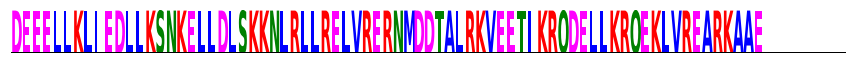

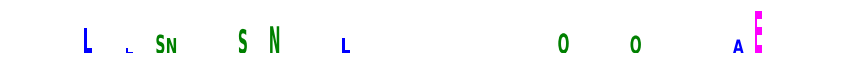

Test sequence 1:


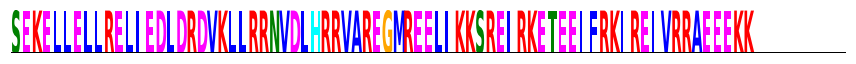

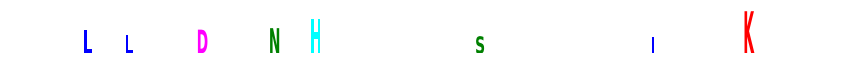

Test sequence 2:


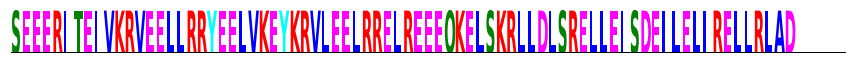

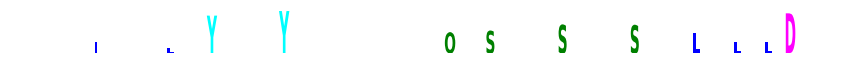

Test sequence 3:


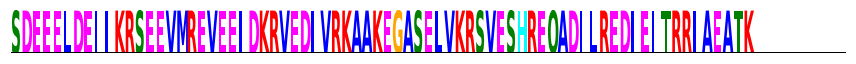

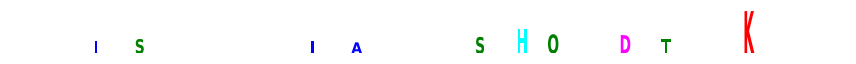

Test sequence 4:


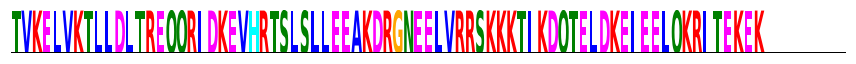

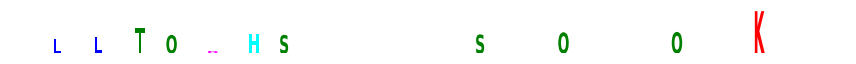

Test sequence 0:


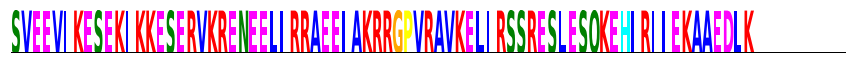

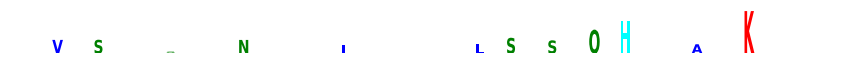

Test sequence 1:


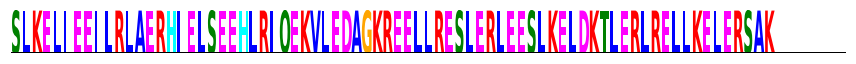

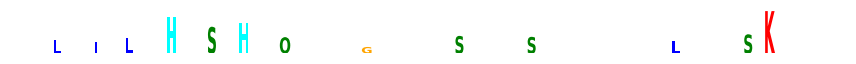

Test sequence 2:


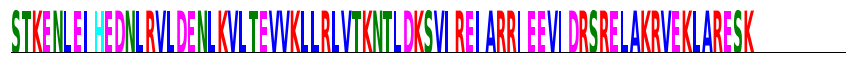

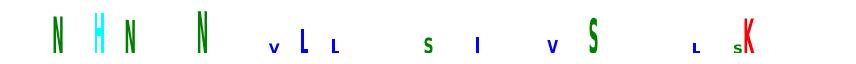

Test sequence 3:


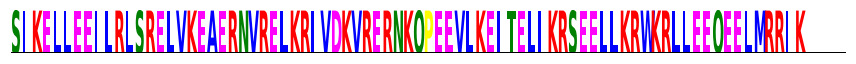

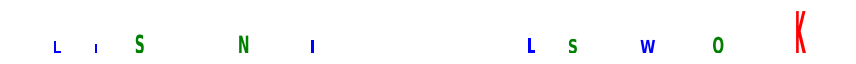

Test sequence 4:


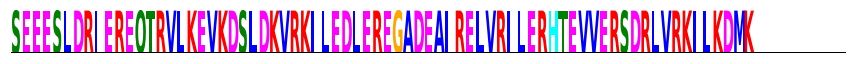

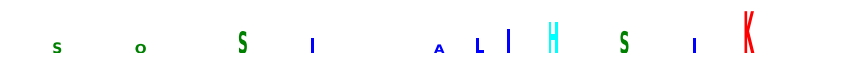

In [21]:
#Visualize importance for binder 1

for plot_i in range(0, 5) :

    print("Test sequence " + str(plot_i) + ":")
    
    sequence_template = sequence_templates[l_1_test[plot_i, 0]]

    plot_protein_logo(residue_map, x_1_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(12, 1), plot_start=0, plot_end=81)
    plot_importance_scores(np.maximum(importance_scores_1_test[plot_i, 0, :, :].T, 0.), encoder.decode(x_1_test[plot_i, 0, :, :]), figsize=(12, 1), score_clip=None, sequence_template=sequence_template, plot_start=0, plot_end=81)

#Visualize importance for binder 2

for plot_i in range(0, 5) :

    print("Test sequence " + str(plot_i) + ":")
    
    sequence_template = sequence_templates[l_2_test[plot_i, 0]]

    plot_protein_logo(residue_map, x_2_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(12, 1), plot_start=0, plot_end=81)
    plot_importance_scores(np.maximum(importance_scores_2_test[plot_i, 0, :, :].T, 0.), encoder.decode(x_2_test[plot_i, 0, :, :]), figsize=(12, 1), score_clip=None, sequence_template=sequence_template, plot_start=0, plot_end=81)


In [23]:
#Save predicted importance scores

model_name = "l2x_" + dataset_name + "_zeropad_rnn"

np.save(model_name + "_importance_scores_1_test", importance_scores_1_test)
np.save(model_name + "_importance_scores_2_test", importance_scores_2_test)


In [17]:
#Binder DHD_154

seq_1 = "TAEELLEVHKKSDRVTKEHLRVSEEILKVVEVLTRGEVSSEVLKRVLRKLEELTDKLRRVTEEQRRVVEKLN"[:81]
seq_2 = "DLEDLLRRLRRLVDEQRRLVEELERVSRRLEKAVRDNEDERELARLSREHSDIQDKHDKLAREILEVLKRLLERTE"[:81]

print("Seq 1 = " + seq_1)
print("Seq 2 = " + seq_2)

encoder = IdentityEncoder(81, residue_map)

test_onehot_1 = np.tile(np.expand_dims(np.expand_dims(encoder(seq_1), axis=0), axis=0), (batch_size, 1, 1, 1))
test_onehot_2 = np.tile(np.expand_dims(np.expand_dims(encoder(seq_2), axis=0), axis=0), (batch_size, 1, 1, 1))

test_len_1 = np.tile(np.array([[len(seq_1)]]), (batch_size, 1))
test_len_2 = np.tile(np.array([[len(seq_2)]]), (batch_size, 1))

pred_interacts = predictor.predict(x=[test_onehot_1[:, 0, ...], test_onehot_2[:, 0, ...]])[0, 0]

print("Predicted interaction prob = " + str(round(pred_interacts, 4)))


Seq 1 = TAEELLEVHKKSDRVTKEHLRVSEEILKVVEVLTRGEVSSEVLKRVLRKLEELTDKLRRVTEEQRRVVEKLN
Seq 2 = DLEDLLRRLRRLVDEQRRLVEELERVSRRLEKAVRDNEDERELARLSREHSDIQDKHDKLAREILEVLKRLLERTE
Predicted interaction prob = 0.8533


In [25]:

x_1_test = test_onehot_1[:1]
x_2_test = test_onehot_2[:1]

#Concatenate input binder pairs

x_test = np.concatenate([x_1_test, x_2_test], axis=2)

#Execute L2X

k = int(np.ceil(0.1 * seq_length * 2))
batch_size = 32
hidden_dims = 64
epochs = 25

importance_scores_test, q_test = L2X(
    x_test,
    np.zeros((1, 2)),
    np.zeros((1, 2)),
    x_test,
    np.zeros((1, 2)),
    np.zeros((1, 2)),
    k=k,
    batch_size=1,
    epochs=epochs,
    hidden_dims=hidden_dims
)

importance_scores_1_test, importance_scores_2_test = importance_scores_test[:, :, :seq_length, :], importance_scores_test[:, :, seq_length:, :]


Creating model...
The train and validation accuracy of the original model is 1.0 and 1.0
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 1, 162, 20)   0                                            
__________________________________________________________________________________________________
conv1_gumbel (Conv2D)           (None, 1, 162, 32)   1952        input_6[0][0]                    
__________________________________________________________________________________________________
new_global_max_pooling1d_1 (Glo (None, 32)           0           conv1_gumbel[0][0]               
__________________________________________________________________________________________________
conv2_gumbel (Conv2D)           (None, 1, 162, 32)   3104        conv1_gumbel[0][0]               
____________________

Test sequence 0:


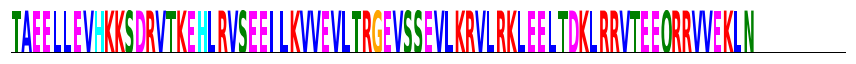

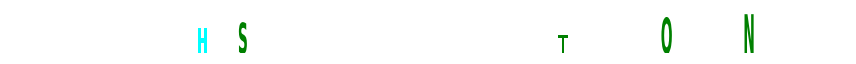

Test sequence 0:


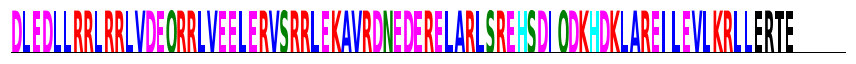

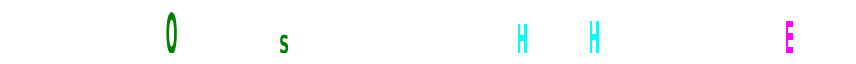

In [28]:

save_figs = True

model_name = "l2x_" + dataset_name + "_zeropad_rnn"

pair_name = "DHD_154"

#Visualize importance for binder 1

for plot_i in range(0, 1) :

    print("Test sequence " + str(plot_i) + ":")
    
    sequence_template = sequence_templates[l_1_test[plot_i, 0]]

    plot_protein_logo(residue_map, x_1_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(12, 1), plot_start=0, plot_end=81)
    plot_importance_scores(np.maximum(importance_scores_1_test[plot_i, 0, :, :].T, 0.), encoder.decode(x_1_test[plot_i, 0, :, :]), figsize=(12, 1), score_clip=None, sequence_template=sequence_template, plot_start=0, plot_end=81, save_figs=save_figs, fig_name=model_name + "_scores_" + pair_name + "_binder_1")

#Visualize importance for binder 2

for plot_i in range(0, 1) :

    print("Test sequence " + str(plot_i) + ":")
    
    sequence_template = sequence_templates[l_2_test[plot_i, 0]]

    plot_protein_logo(residue_map, x_2_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(12, 1), plot_start=0, plot_end=81)
    plot_importance_scores(np.maximum(importance_scores_2_test[plot_i, 0, :, :].T, 0.), encoder.decode(x_2_test[plot_i, 0, :, :]), figsize=(12, 1), score_clip=None, sequence_template=sequence_template, plot_start=0, plot_end=81, save_figs=save_figs, fig_name=model_name + "_scores_" + pair_name + "_binder_2")
